In [1]:
%matplotlib inline

import datetime as dt                                                           

import pandas as pd                                                             
import pandas_datareader.data as web   

import matplotlib.pyplot as plt                                                 
from matplotlib import style  
#from matplotlib.finance import candlestick_ohlc
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
style.use('ggplot') 

# Getting stock price data

In [2]:
start = dt.datetime(2000, 1, 1)                                                 
end = dt.datetime(2017, 10, 31)

In [3]:
# tesla stock
df = web.DataReader('TSLA', 'yahoo', start, end) #Ticker(company), source, dates 
df.to_csv('tsla.csv')
# df.read_csv('tsla.csv', parse_dates=True, index_col=0)
df.tail(5)

# adj-close : adjusted for stock splits when a company decides their price is too high for share.
# Every share is 2 shares actually. 1 share of 1000 becomes 2 of $500. 
# Price suddenly changes (sometimes falls)
# High priceper shareprecludes a lot of people from being ivestors in the company

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-25,336.700012,337.500000,323.559998,325.839996,325.839996,8594100
2017-10-26,327.779999,330.230011,323.200012,326.170013,326.170013,5023500
2017-10-27,319.750000,324.589996,316.660004,320.869995,320.869995,6979700
2017-10-30,319.179993,323.779999,317.250000,320.079987,320.079987,4254400
2017-10-31,320.230011,331.950012,320.179993,331.529999,331.529999,5672300


# Handling data

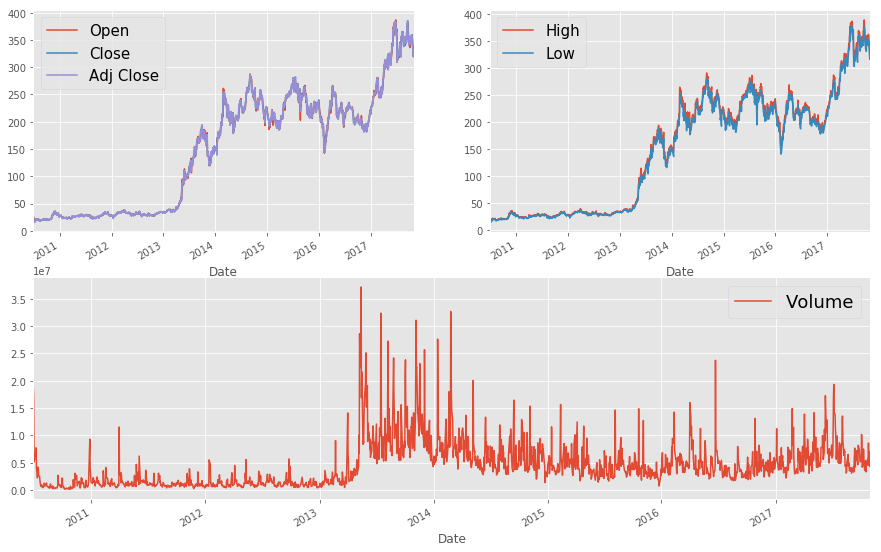

In [4]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

df[['Open', 'Close','Adj Close']].plot(ax=ax1, figsize=(15,10), legend=True)
df[['High','Low']].plot(ax=ax2, figsize=(15,10), legend=True)
df['Volume'].plot(ax=ax3, figsize=(15,10), legend=True)

ax1.legend(prop={'size':15})
ax2.legend(prop={'size':15})
ax3.legend(prop={'size':18})
plt.show();

# Stock Data Manipulation

In [5]:
# 100 day moving average
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()
# df.dropna(inplace=True)

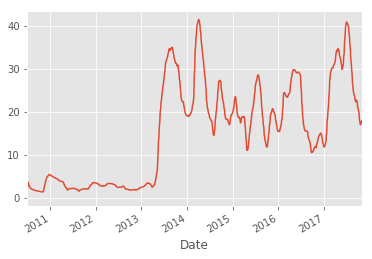

In [6]:
df['Adj Close'].rolling(window=100, min_periods=0).std().plot()

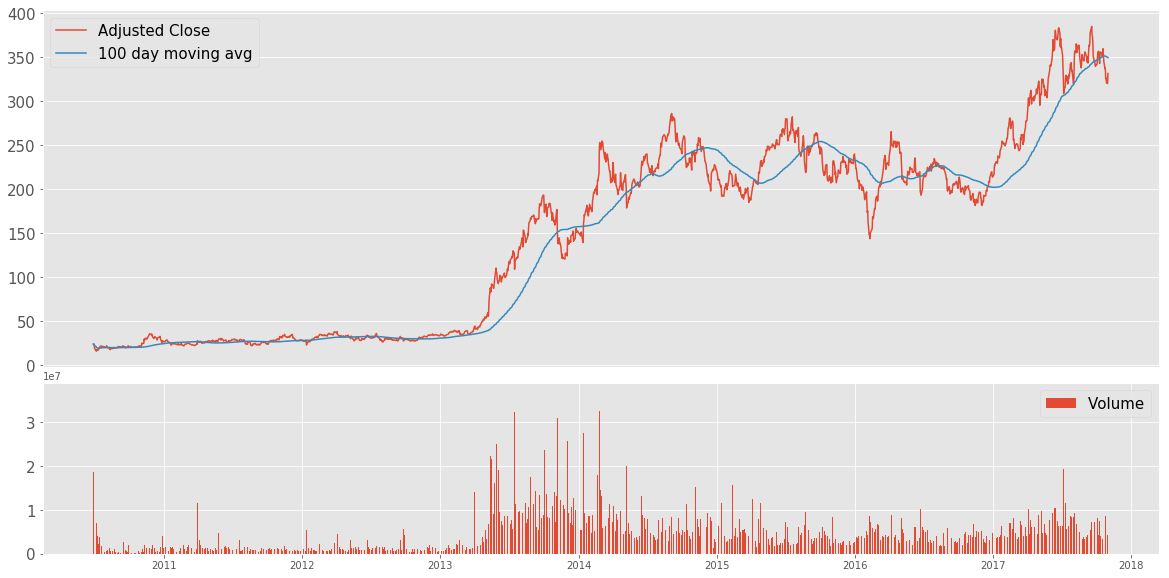

In [28]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((6,1), (4,0), rowspan=2, colspan=1) #, sharex=ax1)

ax1.plot(df.index, df['Adj Close'], label='Adjusted Close')
ax1.plot(df.index, df['100ma'], label='100 day moving avg')
ax2.bar(df.index, df['Volume'], label='Volume')

ax1.legend(prop={'size':15})
ax2.legend(prop={'size':15})
ax1.axes.get_xaxis().set_ticks([])
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
plt.show();

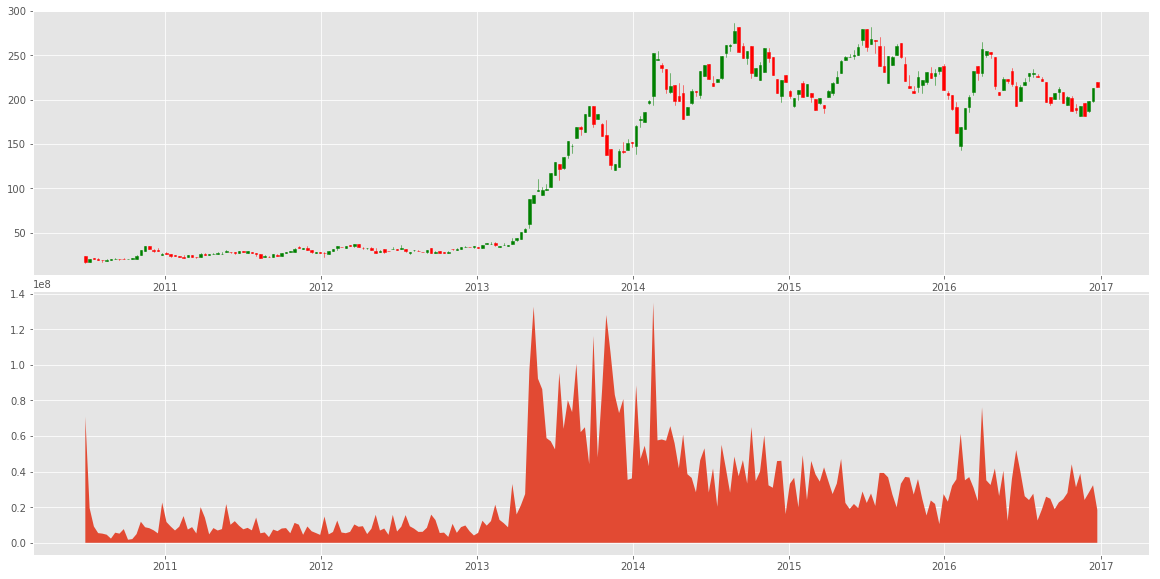

In [60]:
# Resample 
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()

# create a Date colum for the indices
df_ohlc.reset_index(inplace=True)
# convert dates to mdates type
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)


fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=3, colspan=1)
ax2 = plt.subplot2grid((6,1), (3,0), rowspan=3, colspan=1, sharex=ax1)
ax1.xaxis_date()


candlestick_ohlc(ax1, df_ohlc.values, width=6, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values)

#ax1.legend(prop={'size':15})
#ax2.legend(prop={'size':15})
plt.show();

# S&P 500: Scraping from Wikipedia

In [78]:
import os
import bs4 as bs
import pickle
import requests
from pandas_datareader._utils import RemoteDataError

def save_sp500_tickers():
    # get table from wikipedia
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    
    # obtain the tickers for all companies
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.replace('.','').strip('\n'))
    
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    return tickers

def get_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
            
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000, 1, 1)                                                 
    end = dt.datetime(2016, 12, 31)
    for ticker in tickers:
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except RemoteDataError as e:
                print(ticker)
                print(e)
                pass
            
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns={'Adj close', ticker}, inplace=True)
        df.drop(['Open', 'Close', 'High', 'Low', 'Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df

In [79]:
get_from_yahoo(reload_sp500=True)

BRKB
Unable to read URL: http://ichart.finance.yahoo.com/table.csv?s=BRKB&a=0&b=1&c=2000&d=11&e=31&f=2016&g=d&ignore=.csv
BFB
Unable to read URL: http://ichart.finance.yahoo.com/table.csv?s=BFB&a=0&b=1&c=2000&d=11&e=31&f=2016&g=d&ignore=.csv
